<a href="https://colab.research.google.com/github/jarrydmartinx/supervised-learning/blob/master/Classification_with_Sonnet_and_TensorFlow_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Classification Models with Sonnet on TensorFlow Datasets

## Overview

### TensorFlow: Training neural networks with gradient descent
TensorFlow is an open source machine learning library. It can do lots of things, but the thing it does best is automatic differentiation, which is great for training parametrised ML models using gradient methods. That means it's great for training neural networks with (some form of) stochastic gradient descent. That's what we're going to do below. Specifically, we're going to train a number of neural network models to do classification on a number of datasets.

### Sonnet: Constructing neural network models without getting in too deep
Sonnet is a library that contains neural network modules for use with TensorFlow. It was developed by Google Deepmind, principally to do cutting edge machine learning research. It does a lot of the things that Keras does, if you've heard of Keras. There's a lot of "how to Keras" stuff online, e.g. on the TensorFlow Tutorials page. There's hardly any stuff about Sonnet, so I wanted to make a simple working example that uses Sonnet modules to do classification. So what's a Sonnet module?
* Each module is a Python object which conceptually "owns" any variables required in that part of the Neural Network. 
* The __call__ function on the object is used to connect that Module into the Graph, and this may be called repeatedly with sharing automatically taking place.

### TensorFlow Datasets API: A nice way to get data into a TensorFlow model
* TensorFlow Datasets provides ...

In [0]:
#@title Install plotting tools
! pip install -q plotnine

In [0]:
#@title Imports

import collections

import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import plotnine as gg

from typing import Dict, Text

## Getting a dataset from TensorFlow Datasets

In [0]:
#@title Checking Metadata for TensorFlow Datasets

def get_metadata(dataset_name: Text):
  """Extracts and checks some necessary metadata for the dataset
  
  Args:
    dataset_name: The name of the dataset. See tfds.list_builders() for a list
    of names. Many of these will not have the necessary format/metadata.
    
  Returns:
    num_classes: The number of categories in the label set.
    input_shape: The shape of the input (e.g. the image shape)
    input_dtype: The datatype of the input (e.g. uint8)
  """
  builder = tfds.builder(dataset_name)
  
  try:
    num_classes = builder.info.features['label'].num_classes
  except (KeyError, AttributeError):
    raise KeyError("The label metadata for the dataset couldn't be found.")
  try:
    input_shape = builder.info.features['image'].shape
    input_dtype = builder.info.features['image'].dtype
  except (KeyError, AttributeError):
    raise KeyError("The input metadata (shape and/or dtype) couldn't be found.")
  
  if input_shape[1] == None or input_shape[2] == None:
    raise ValueError(
        'Inputs must have constant shape (e.g. images should be the same size')
  
  return num_classes, input_shape, input_dtype

In [0]:
#@title Loading a Dataset for Classification from TensorFlow Datasets

# Define a container for our data that has the metadata we need.
DataContainer = collections.namedtuple('DataContainer',
                                   ['num_train_examples', 'num_test_examples',
                                    'train_inputs', 'train_outputs',
                                    'test_inputs', 'test_outputs'])

def get_data(dataset_name: Text,
             train_batch_size: int,
             test_batch_size: int,
            ) -> DataContainer:
  """Loads a dataset using TensorFlow Datasets (tfds).
  
  Args:
    dataset_name: See tfds.list_builders() for a list of names.
    
  Returns:
    data: a DataStuff namedtuple containing training and test data tensors
      and other information about the dataset.
  """
  
  # Get a dataset builder from the TensorFlow Datasets library.
  builder= tfds.builder(dataset_name)
  
  # Download the dataset. Extract and check metadata.
  # The first time you run this it will download it. After that, it's cached.
  
  config = tfds.download.DownloadConfig(compute_stats=False)
  builder.download_and_prepare(download_config=config)
  dataset_info = builder.info
  try: 
    num_train_examples = dataset_info.splits['train'].num_examples
    num_test_examples = dataset_info.splits['test'].num_examples
  except KeyError:
    raise KeyError("The dataset doesn't have the expected train/test split")
  
  
  # Extract the training and test datasets as tf.data.Dataset objects.
  train_dataset = builder.as_dataset(split=tfds.Split.TRAIN)
  test_dataset = builder.as_dataset(split=tfds.Split.TEST)
  
  # Apply pipelining operations here, (repeating infinitely, batching).
  train_dataset = train_dataset.repeat().batch(train_batch_size)
  test_dataset = test_dataset.repeat().batch(test_batch_size)

  # Make train/test iterators. These spit out data in batches!
  train_iterator = train_dataset.make_one_shot_iterator()
  test_iterator = test_dataset.make_one_shot_iterator()

  # 'train_batch' and 'test_batch' are now ops/tensors that draw batches.
  train_batch = train_iterator.get_next()
  test_batch = test_iterator.get_next()

  # Cast image data and labels to tf.float32, because TensorFlow expects that.
  train_images = tf.cast(train_batch['image'], tf.float32)
  train_labels = tf.cast(train_batch['label'], tf.int32)
  test_images = tf.cast(test_batch['image'], tf.float32)
  test_labels = tf.cast(test_batch['label'], tf.int32)
  
  return DataContainer(
      num_train_examples=num_train_examples,
      num_test_examples=num_test_examples,
      train_inputs=train_images,
      train_outputs=train_labels,
      test_inputs=test_images,
      test_outputs=test_labels,
  )

## Train our classifier

In [0]:
def train_classifier(model: snt.AbstractModule,
                     dataset_name: Text,
                     train_batch_size: int = 32,
                     test_batch_size: int = 1000,
                     learning_rate: float = 1e-3,
                     num_training_steps: int = 1000,
                     log_every: int = 20,
                    ) -> pd.DataFrame:
  """Trains a classifier on a dataset from TensorFlow Datasets.
  
  Args:
    model: A Sonnet module that we're going to train.
    dataset_name: A string (e.g. "mnist") that specifies the dataset to load.
    batch_size: The batch size for training.
    test_batch_size: The size of the 'batch' for computing test accuracy.
    learning_rate: The learning rate for our (Adam) optimizer.
    num_training_steps: How long to train for.
    log_every: How often to compute the accuracy (for analysis).
    
  Returns:
    A Pandas dataframe containing the results of training.
  """

  # Get the data.
  data = get_data(dataset_name, train_batch_size, test_batch_size)
  
  print(data.train_inputs)
  
  # This is the tensor output by the sonnet module after we input a batch of data
  y_train = model(data.train_inputs) # y_train has shape [batch_size, num_classes]
  y_test = model(data.test_inputs)

  # We're doing classification, so we use softmax cross entropy loss.
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data.train_outputs,
                                                        logits=y_train,
                                                        name='loss')
  mean_batch_loss = tf.reduce_mean(loss)

  # Make an optimizer and an SGD op.
  optimizer = tf.train.AdamOptimizer(learning_rate)
  sgd_op = optimizer.minimize(loss)

  # Test set predictions.
  prediction = tf.argmax(y_test, 
                         axis=1, 
                         output_type=tf.int32, 
                         name='prediction') # shape [32, 1] ??

  # Test batch accuracy.
  # TODO(jarryd): Compute the accuracy over the whole test set (?)
  accuracy_op = tf.reduce_mean(tf.cast(tf.equal(prediction, data.test_outputs), 
                                       tf.float32), name='accuracy')

  # Make session.
  session = tf.Session()
  session.run(tf.global_variables_initializer())

  # Make callables.
  test_accuracy = session.make_callable(accuracy_op)
  sgd_step = session.make_callable(sgd_op)
  
  # Training loop.
  results = []
  for step in range(num_training_steps):
    sgd_step()
    if step % log_every == 0:
      result = {'iteration': step,
                'accuracy': test_accuracy(),
               }
      results.append(result)
  
  session.close()
  return pd.DataFrame(results)

In [0]:
#@title Training

tf.reset_default_graph() 

# This dataframe will hold our results.
df = pd.DataFrame()
for dataset_name in ['fashion_mnist', 'mnist']:
  # Get dataset info.
  num_classes, _, _ = get_metadata(dataset_name)
  
  # Make our models.
  models = {
    'conv': snt.Sequential([
        snt.nets.ConvNet2D(output_channels=[8, 16, 16],
                           kernel_shapes=[5, 3, 3],
                           strides=[2, 2, 1],
                           paddings=[snt.SAME]),
        snt.BatchFlatten(),
        snt.nets.MLP(output_sizes=[50]),
    ], name='Conv'),
    'mlp': snt.Sequential([
        snt.BatchFlatten(),
        snt.nets.MLP([50, 50, num_classes]),
    ], name='MLP'),
    'linear': snt.Sequential([
        snt.BatchFlatten(),
        snt.Linear(num_classes),
    ], name='Linear'),
  }

  # Train each model.
  for model_name, model in models.items():
    print('Training model: {} on dataset: {}...'.format(model_name, dataset_name))
    results = train_classifier(model,
                               dataset_name=dataset_name, 
                               train_batch_size=32,
                               test_batch_size=100,
                               num_training_steps=2000)
    results['model'] = model_name
    results['dataset'] = dataset_name
    df = pd.concat([df, results])

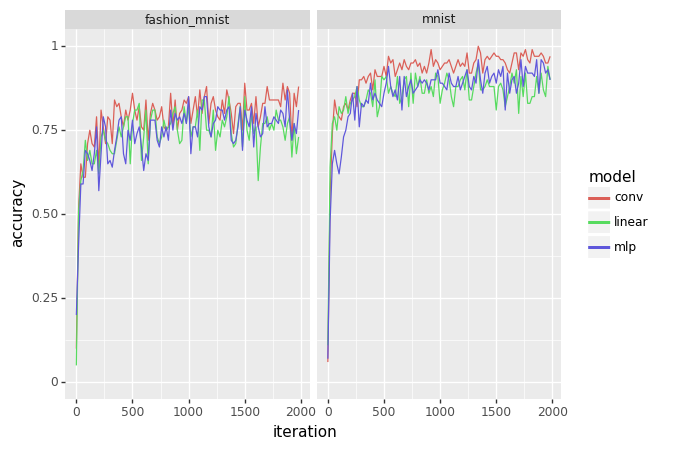

<ggplot: (-9223363281489204620)>

In [0]:
p = (gg.ggplot(df)
     + gg.aes(x='iteration', y='accuracy', color='model')
     + gg.facet_wrap('dataset')
     + gg.geom_line()
     + gg.ylim([0, 1])
    )
p

## Playground

In [0]:
#@title Looking at Our Dataset

# # See, `data` is a dictionary containing "images" and "labels" tensors.
# # Note dtype (unsigned 8-bit integer). We're probably going to have to cast this
# # to float and re-scale {0,...,255} 
# print(data)
# print(type(data))

# # Let's take a look at our data. It's a dict of numpy arrays
# # The shape of one batch of images is (32, 28, 28, 1)
# # 32 images of size 28x28 with 1 channel (grayscale) of dtype uint8
# # 32 labels of type int64
# with tf.train.MonitoredSession() as sess:
#   train_data = sess.run(data)

# print('Type of output: {}, Contents: {}, {}'.format(type(things), 
#                                                     type(things['image']), 
#                                                     type(things['label'])))

# print('Shape of images: {}'.format(things['image'].shape))

# print('dtype of data: images {}, labels {}'.format(things['image'].dtype,
#                                                    things['label'].dtype))

# plt.imshow(things['image'][0].squeeze())
# plt.axis('off')  
# plt.show()
# print('Label: ', things['label'][0])